# Welcome to the Neural Network assisted sleep state classifier!

### This notebook walks us through some features of the dataset, visualizations, and model evaluation



In [ ]:
import tensorflow as tf
from tensorflow import keras
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os
from numpy import genfromtxt
from datetime import datetime
import random
from sklearn.model_selection import train_test_split ##Need to randomly split data
from main import CONFIG_PATH
import seaborn as sns

from sklearn.manifold import TSNE
from functions.hypnogram_postprocess import postProcessHypnogram
from functions.helper_functions import *
from sklearn.preprocessing import normalize
from operator import itemgetter


#from keras.layers import Embedding,  LSTM
from main import CONFIG_PATH
config = load_config(CONFIG_PATH / "my_config.yaml")
globals().update(config)



## Specify demo directory

In [2]:
# Specify demo directory
WORKING_DIR = "G:/sleep_DNN/data"
SESSION_ID = "02-25"
currentModel = WORKING_DIR + "/model_hypnogram"



# Load Train and Test Data


Data is comprised of 28 hours at 2Hz, hence a size of 201600. 

# Data Details

First 318 features are from the neural signal while the final feature contains movement information. This dataset is comprised of a 28 hour recording of the animal behaving normally. There are some times when the animal sleeps, while most of the time it is awake. For sleep classification, I took one of the channels recording neural signals, performed frequency decomposition, and generated these features. The final feature contains positional information from which velocity can be calculated. This positional information is generated from DeeplabCut, a markerless pose-estimation toolbox using neural networks. 

There are 4 labels: Rapid eye movement ```(REM)```, Non-REM ```(NREM)```, ```awake```, or ```unclassified```. Typically, as organisms progress through the sleep cycle, the brain transitions from ```Awake -> NREM -> REM```. From ```REM```, the animal can either immediately transition to ```Awake``` or ```NREM```. In our recordings, there are artifacts typically from signal saturation - these epochs are labeled as ```unclassified```. 

In [3]:
def loadInputData(filename):
    DATA_DIR = WORKING_DIR + filename
    LABEL_DIR = DATA_DIR.replace('_data.csv', '_labels.csv')
    print('Loaded labels for: ' + filename)
    print(DATA_DIR)
    
    ## Now, call pandas and load data
    train_data = pd.read_csv(DATA_DIR, header=None, delimiter=',').to_numpy()
    train_labels = pd.read_csv(LABEL_DIR, header=None, delimiter=',').to_numpy()
    
    return train_data, train_labels
    
filename = '/model_spectrogram_' + SESSION_ID + '_data.csv'
train_data, train_labels = loadInputData(filename)

hypnogramOrig = onehot_to_array(train_labels)
hypTimeAxis = np.linspace(1/hypFs, len(hypnogramOrig)/hypFs, len(hypnogramOrig))
print('Here are the shapes of our dataset')
print('Data: ' + str(train_data.shape))
print('Labels: ' + str(train_labels.shape))
print(train_data[:10,:])
print(train_labels[:10,:])

dfLabels = pd.Categorical(hypnogramOrig, categories=['Awake','Unc', 'NREM', 'REM'])

Loaded labels for: /model_spectrogram_02-25_data.csv
G:/sleep_DNN/data/model_spectrogram_02-25_data.csv
Here are the shapes of our dataset
Data: (201600, 319)
Labels: (201600, 4)
[[0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [6.8858 7.5332 7.8917 ... 4.5304 4.6347 4.7837]
 [6.896  7.5042 7.8894 ... 4.5653 4.674  4.8218]]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


## Let's take a look at the label distribution as well as the features across time



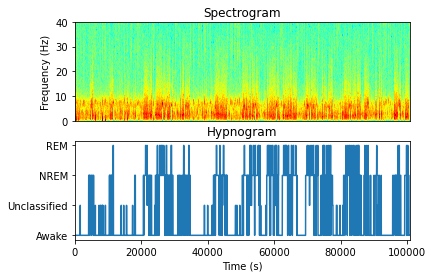

In [35]:
## Plot only the frequency specific information

plt.figure();
plt.subplot(211);
plt.imshow(np.transpose(train_data[:,0:318]), aspect='auto', origin='lower',cmap='jet')
plt.xticks([]);
plt.clim([0,8])
plt.yticks(ticks=[0, 80, 160, 240, 318], labels=[0, 10,20,30,40])
plt.ylabel('Frequency (Hz)');
plt.title('Spectrogram');


plt.subplot(212);
plt.plot(hypTimeAxis, hypnogramOrig);
plt.yticks(ticks=[0,1,2,3], labels=['Awake', 'Unclassified', 'NREM', 'REM']);
plt.xlabel('Time (s)');
plt.xlim([0,max(hypTimeAxis)]);
plt.title('Hypnogram');

### We can see that the REM states occur less often than the NREM and Awake states


In [4]:
stateLabels = ['Awake', 'Unclassified', 'NREM', 'REM']
dfHypnogram = [stateLabels[i] for i in hypnogramOrig]
dfLabels = pd.Categorical(dfHypnogram)
dfLabels.describe()


,counts,freqs
categories,,
Awake,109182,0.541577
NREM,77243,0.383150
REM,10577,0.052465
Unclassified,4598,0.022808


### I know that key features are theta-delta ratio for REM, as well as delta power + frequency variance for NREM, so let's check the distribution for those features



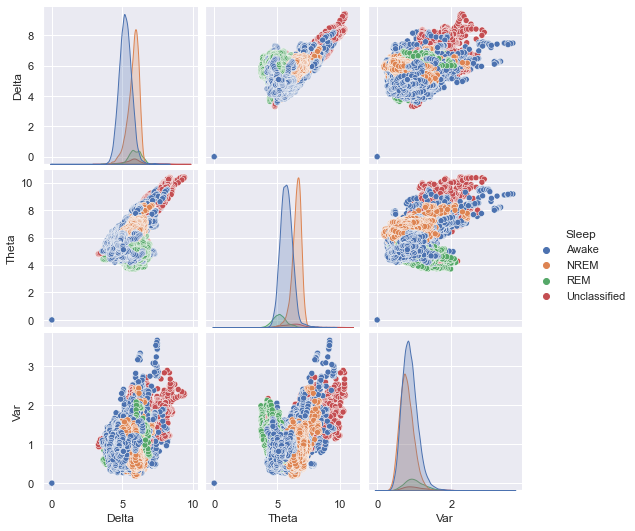

In [116]:
thetaRange = slice(40,80,1)
deltaRange = slice(10,40,1)
varFreq = slice(10, 120, 1)
deltaPower = np.mean(train_data[:,thetaRange], axis=1)
thetaPower = np.mean(train_data[:,deltaRange],axis=1)
varPower = np.var(train_data[:,varFreq], axis=1)

df = pd.DataFrame({"Delta":deltaPower, "Theta":thetaPower, "Var":varPower, "Sleep":dfLabels})
df.head()
#df.groupby("Sleep").describe()

sns.pairplot(df,hue="Sleep")


In [90]:
df2 = pd.DataFrame(train_data)
corr = df2.corr()


<AxesSubplot:>

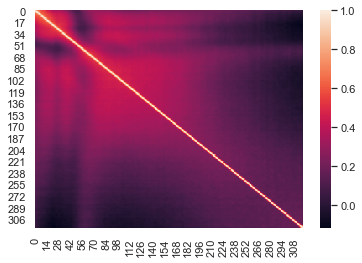

In [91]:
sns.heatmap(corr);

In [7]:

## Techniques to rebalance the data would be either downsaampling the majority class or artificially 
## resampling the minority class using SMOTE. Current method is simply downsampling
def rebalanceData(x_train, y_train):
    ##Check class distribution
    storeAllocated = []
    x_out = np.empty((0,319))
    y_out = np.empty((0,4))
    #[print("s" + str(s) + ":" +  str(len(np.argwhere(y_train[:,s] == 1)))) for s in range(0,4)]

    for s in range(0,4):
        toExtract = np.argwhere(y_train[:,s] == 1).flatten()
        storeAllocated.append(toExtract)#y_train[toExtract,])
    minNum = len(storeAllocated[3])
    
    ##For Awake, NREM, and REM. For unclassified, append as is, or remove half
    for s in [0,2,3]:
        toAllocate = random.sample([storeAllocated[s][i] for i in range(0,len(storeAllocated[s]))], minNum)
        x_out = np.append(x_out, np.array(x_train[toAllocate,:]), axis=0)
        y_out = np.append(y_out, np.array(y_train[toAllocate,:]), axis=0)
        
    x_out = np.append(x_out, np.array(x_train[storeAllocated[1],:]), axis=0)
    y_out = np.append(y_out, np.array(y_train[storeAllocated[1],:]), axis=0)
    
    return x_out, y_out



x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.2, shuffle= True)
x_train, y_train = rebalanceData(x_train, y_train) ##Utilize a form of downsampling rather than synthetic data



# t-SNE Visualization

With t-SNE we can better visualize our dataset in two dimensions. It is better at visualizing distinct clusters as opposed to simply plotting the first two principal components. We can immediately notice that the ```Unclassified``` label is scattered across the other labels, while Awake, NREM, and REM are in their individual clusters.

In [120]:
x_train.shape
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=300)
tsne_results = tsne.fit_transform(x_train[slice(0,29000,10),0:300])



[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 2900 samples in 0.038s...
[t-SNE] Computed neighbors for 2900 samples in 4.877s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2900
[t-SNE] Computed conditional probabilities for sample 2000 / 2900
[t-SNE] Computed conditional probabilities for sample 2900 / 2900
[t-SNE] Mean sigma: 3.648580
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.913666
[t-SNE] KL divergence after 300 iterations: 1.878134


<AxesSubplot:xlabel='dim1', ylabel='dim2'>

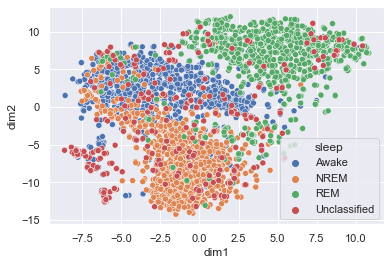

In [121]:
curLabels = onehot_to_array(y_train)
curLabels = [stateLabels[int(i)] for i in curLabels]
# curLabels.shape
df_tsne = pd.DataFrame({"dim1": tsne_results[:,0], "dim2": tsne_results[:,1], "sleep": curLabels[slice(0,29000,10)]})
sns.scatterplot(data=df_tsne, x="dim1",y="dim2", hue="sleep") 
# tsne_results.shape

# Designing Neural Network Architecture

Prior to the Neural Network I tried running multinomial logistic regressions and some classic ML models like decision trees and random forests. Eventually, I implemented the Neural Network and it performed spectacularly. I also experimented with various feature inputs until I settled for the 319 features used in this Neural Network. 

I did consider dimensionality reduction since some of these features may be redundant, but there are nuances in the smaller frequency steps which allow the model to selectively discriminate between sleep states.

I chose to build a deeper network since there's evidence that deeper networks are advantageous to shallow networks at classification. I batch normalized each layer, and added dropout layers to improve generalization. The ReLU activation function was chosen since it performs better than the sigmoid or tanh activation functions. I fiddled with the loss rate for some time, and found the default rate set by the Adam optimizer was sufficient. 

I found out about GridSearch from sklearn after I manually tuned my hyperparameters, so I will certainly start with that on my next models. 

In [24]:

## Batch normalization 
def buildDNN(lr=0.05, dropout=0.5,optimizer="sgd"):
    model = keras.Sequential()

    model.add(keras.layers.Dense(10,activation='relu', input_shape=(319,)))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(12, activation='relu'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(4, activation='softmax',input_shape=(4,)))

    model.compile(optimizer="adam",#keras.optimizers.Adam(lr=0.005),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'categorical_accuracy'])

    model.summary()
    
    
    return model

model = buildDNN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                3200      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                704       
_________________________________________________________________
batch_normalization_14 (Batc (None, 64)                256       
_________________________________________________________________
dense_20 (Dense)             (None, 256)               16640     
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
__________

# Begin training the Neural Network

Data will be randomly 80-20 split over 10 folds for better generalization. Since REM states are the minority class, we downsample the majority class to accommodate. There are future plans to implement SMOTE for minority class upsampling.

Perform a grid search for the optimal learning rate and optimizer

In [25]:
acc, val_acc, loss,val_loss = [],[],[],[]
    

## Running k-folds classification to improve generalization and reduce overfitting
for i in range(0,5):

    ##Only need to balance the training data, not the validation data.
    x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.2, shuffle= True)
    x_train, y_train = rebalanceData(x_train, y_train) ##Utilize a form of downsampling rather than synthetic data
    history = model.fit(x_train, y_train, batch_size=1800, epochs=150, validation_data=(x_valid, y_valid), verbose=0)#, callbacks=[lrs])

    # acc.append(history.history['accuracy'])
    # val_acc.acc(history.history['val_accuracy'])
    acc.append(history.history['acc'])
    val_acc.append(history.history['val_acc'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    print('Acc: {} - loss {}'.format(round(history.history['acc'][0],2), round(history.history['loss'][0],2)))
    print('Val acc: {} - Val loss {}'.format(round(history.history['val_acc'][0],2), round(history.history['val_loss'][0],2)))

print("Finished model fitting")

Acc: 0.46 - loss 1.31
Val acc: 0.02 - Val loss 3.41
Acc: 0.87 - loss 0.37
Val acc: 0.84 - Val loss 0.46
Acc: 0.88 - loss 0.33
Val acc: 0.84 - Val loss 0.41
Acc: 0.89 - loss 0.31
Val acc: 0.86 - Val loss 0.41
Acc: 0.88 - loss 0.33
Val acc: 0.86 - Val loss 0.42
Finished model fitting


# Plot Loss and accuracy

In [26]:
print("Starting prediction...")
predictedHypnogram = model.predict(train_data)
# Serialize model to JSON
predictedHypnogram = np.array(predictedHypnogram)
    
print("Starting post-processing...this may take a while")
newPredict, newProbVal = postProcessHypnogram(predictedHypnogram)




Starting prediction...
Starting post-processing...this may take a while


In [27]:
acc_all = np.array(acc).flatten().tolist()
valacc_all = np.array(val_acc).flatten().tolist()
loss_all = np.array(loss).flatten().tolist()
valloss_all = np.array(val_loss).flatten().tolist()
epochs = range(len(acc_all))


## We can see that learning tapers off around 100 epochs. We do see training loss and accuracy increase over epochs, while the validation loss remains the same. This may indicate overfitting by not including a diverse enough dataset. 

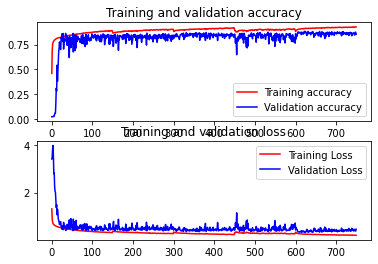

In [28]:
# Plot evaluations
plt.figure()
plt.subplot(211)
plt.plot(epochs, acc_all, 'r', label='Training accuracy')
plt.plot(epochs, valacc_all, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.subplot(212)
plt.plot(epochs, loss_all, 'r', label='Training Loss')
plt.plot(epochs, valloss_all, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()



## Evaluation with ground truth

Overall, the model is quite accurate after some post-processing procedures. We reach an overall accuracy of 99% on REM after post-processing on this individual dataset. The overall accuracy is brought down by misclassifications of the Unclassified label, since unclassified can be comprised of either artifacts across the whole feature set, or simply a few in the lower frequencies which will leave to mis classifications. 



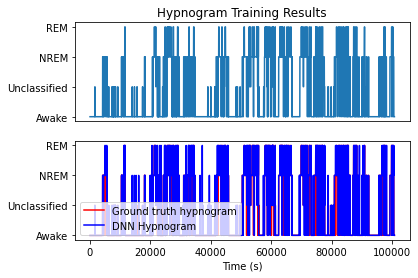

                 Awake Actual  Unc Actual  NREM Actual  REM Actual
Awake Predicted      0.945879    0.003352     0.018529    0.032240
Unc Predicted        0.199870    0.696390     0.068073    0.035668
NREM Predicted       0.026320    0.002615     0.945212    0.025853
REM Predicted        0.002080    0.000000     0.008131    0.989789
Accuracy: 0.89   F1 score: 0.89


In [29]:

hypnogramOrig = onehot_to_array(train_labels)
storeAcc, hFig,accuracy,F1 = plotValidation(hypTimeAxis, hypnogramOrig, newPredict) ## Plot both the original and DNN output

print("Accuracy: {}   F1 score: {}".format(round(accuracy,2), round(F1,2)))



# Summary

The model is overfitting in this example due to only being trained on one dataset. However, recordings from multiple days and animals were included for the neural network deployed in my lab pipeline. 

Some future steps would be a recurrent neural network due to the temporal dependency of the dataset. For example, if one label is NREM, it is probabilistically more likely for the previous and next states to be NREM as well, since transition states are rare in the overall data. 